## On Demand Training Data from Radiant MLHub and Planetary Computer

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

In this tutorial, we will walk through the process of requesting on-demand traning data from the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/catalog) to pair with the [BigEarthNet](https://mlhub.earth/data/bigearthnet_v1) dataset downloaded from Radiant MLHub. This is an important workflow for someone in the geospatial community who wants to train an ML model on a datasource outside of a prepackaged dataset, such as those found on MLHub. They can start with any dataset containing source image and label collections in STAC, obtain a random sample to work with, fetch source images from a different collection or satellite product, and then reproject and crop those images to match the spatial and temporal extent of the original dataset.

**NOTE:** because the workflow documented below uses libraries like `pystac_client` and `stackstac`, the datasets queried need to be organized into STAC Collections.

Let's start by importing the Python libraries we'll use in this notebook.

In [ ]:
!pip install --upgrade wget # not installed on PC by default

In [1]:
import getpass
import tempfile
from pathlib import Path
import os
import json
from glob import glob
import requests
from typing import List, Tuple
from datetime import datetime as dt
from datetime import timedelta as td

from radiant_mlhub import Collection
import planetary_computer
import pystac_client
from pystac import ItemCollection, Item, Asset
from dask import delayed, compute, distributed

import numpy as np
from stackstac import stack
from geopandas import GeoDataFrame
import rasterio as rio
import rioxarray
from xarray import DataArray
from shapely.geometry import shape
from shapely.geometry import Polygon
from pyproj import CRS

/Users/kendallsmith/opt/anaconda3/envs/mlhub/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.0-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Define global variables

In addition to the API key, we will also need to define some other initial global variables to get our workflow started. e.g. a temporary working directory to download and write data to, the STAC API endpoints, names of Collections, and other variables like the RGB bands for those collections. These are pretty flexible depending on your individual needs.

In [60]:
# Temporary working directory on local machine or PC instance
TMP_DIR = tempfile.gettempdir()

# API endpoints for MLHub and Planetary Computer catalogs
MLHUB_API_URL = "https://api.radiant.earth/mlhub/v1"
MSPC_API_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"

# Names of Collections that will be queried against using pystac_client
BIGEARTHNET_SOURCE_COLLECTION = "bigearthnet_v1_source"  # sentinel-2 source imagery
BIGEARTHNET_LABEL_COLLECTION = "bigearthnet_v1_labels"  # geojson classification labels
PLANETARY_COMPUTER_LANDSAT_8 = "landsat-8-c2-l2"  # landsat 8 source imagery on PC
OUTPUT_DIR = "landsat_8_source"

# Default variables that will be used in the API queries
BIGEARTHNET_TIME_RANGE = "2017-06-01/2018-05-31"  # full date range for BigEarthNet
LABEL_CRS = CRS("EPSG:4326")
DATE_BUFFER = 60
LANDSAT_8_RGB_BANDS = ["SR_B4", "SR_B3", "SR_B2"]  # names of RGB bands from BigEarthNet
BIGEARTHNET_RGB_BANDS = ["B04", "B03", "B02"]  # names of RGB bands from PC Landsat 8

# Bounding box for demonstration fetching Items over Luxembourg
LUXEMBOURG_AOI = [6.06, 49.58, 6.21, 49.66]  # aoi around Luxembourg

### Authentication with Radiant MLHub

Programmatic access to the Radiant MLHub API using the `pystac_client` library requires both the API end-point and an API key. You can obtain an API key for free by registering an account on [mlhub.earth](https://mlhub.earth/). This can be found under `Settings & API Key` from the drop-down once logged in.

In [3]:
MLHUB_API_KEY = getpass.getpass(prompt="MLHub API Key: ")

MLHub API Key:  ································································


Once you have your API key, you need to update the default profile file in your home directory. You can use the `mlhub configure` command line tool to do this:

In [4]:
!mlhub configure --api-key={MLHUB_API_KEY}

Overwrite existing API Key (****b0eced) [y/N]: ^C
Aborted!


### Configure API connection to Radiant MLHub

This makes a connection to the Radiant MLHub Data Catalog using the API endpoint URL, and the API key from your account.

In [4]:
mlhub_catalog = pystac_client.Client.open(
    url=MLHUB_API_URL, parameters={"key": MLHUB_API_KEY}, ignore_conformance=True
)

### Fetch label items from BigEarthNet over Luxembourg

We will now use the `search` function from the API client to get label Items over Luxembourg as a sample use-case.

In [5]:
origin_label_items = mlhub_catalog.search(
    collections=BIGEARTHNET_LABEL_COLLECTION,
    bbox=LUXEMBOURG_AOI,
    datetime=BIGEARTHNET_TIME_RANGE,
).get_all_items()

In [6]:
len(origin_label_items)

178

This is another helper function that simply displays the geometry for labels from an ItemCollection overlayed on a map of the region.

In [7]:
def explore_search_extent(items: ItemCollection) -> None:
    """Extracts geometry from ItemCollection to display polygons on a map.

    Args:
        items: ItemCollection of Items retrieved from pystac_client search

    Returns:
        GeoDataFrame object with the .explore() method called
    """
    item_feature_collection = items.to_dict()
    geom_df = GeoDataFrame.from_features(item_feature_collection).set_crs(4326)
    print(geom_df.bounds)
    return geom_df[["geometry", "datetime"]].explore(
        column="datetime", style_kwds={"fillOpacity": 0.2}, cmap="viridis"
    )

Here are the BigEarthNet chips with their bounding boxes that matched the spatial parameters for the city of Luxembourg and surrounding areas.

In [8]:
explore_search_extent(origin_label_items)

         minx       miny      maxx       maxy
0    6.197958  49.579464  6.215240  49.590700
1    6.198663  49.590240  6.215949  49.601477
2    6.199368  49.601017  6.216659  49.612254
3    6.180682  49.569146  6.197958  49.580381
4    6.181383  49.579923  6.198663  49.591158
..        ...        ...       ...        ...
173  6.151709  49.634721  6.169003  49.645951
174  6.152406  49.645498  6.169703  49.656729
175  6.153102  49.656275  6.170404  49.667506
176  6.135808  49.645951  6.153102  49.657180
177  6.136501  49.656729  6.153800  49.667957

[178 rows x 4 columns]


### Download the entire label collection for BigEarthNet from Radiant MLHub

We could certainly use the method above to query label Items directly from our connection to the Radiant MLHub API endpoint. However, on very large collections, such as in the case with BigEarthNet, pagination becomes a bottleneck issue in obtaining and resolving STAC items, as it only returns 100 items at a time.  Querying the entire Collection of nearly ~600,000 Items could take hours.

Therefore, downloading the label Collection (which is only 160 MB) directly is preferrable to paginating over the entire Collection using the API.

In [9]:
label_collection_path = os.path.join(
    TMP_DIR, BIGEARTHNET_LABEL_COLLECTION, "collection.json"
)

Check if collection folder already exists before downloading 173 mb dataset. Otherwise download and uncompress the `.tar.gz` file to extract the label collection files.

In [10]:
if not os.path.exists(label_collection_path):
    collection = Collection.fetch(BIGEARTHNET_LABEL_COLLECTION)
    archive_path = collection.download(TMP_DIR)
    !tar -xf {archive_path.as_posix()} -C {TMP_DIR}
else:
    print("Archive file already downloaded from Radiant MLHub, skipping...")

  0%|          | 0/173.0 [00:00<?, ?M/s]

In [11]:
bigearthnet_dir = os.listdir(os.path.join(TMP_DIR, BIGEARTHNET_LABEL_COLLECTION))
bigearthnet_dir[0:5]

['bigearthnet_v1_labels_S2B_MSIL2A_20170914T93030_63_71',
 'bigearthnet_v1_labels_S2B_MSIL2A_20180506T105029_52_1',
 'bigearthnet_v1_labels_S2B_MSIL2A_20180509T092029_4_62',
 'bigearthnet_v1_labels_S2B_MSIL2A_20180525T94030_57_6',
 'bigearthnet_v1_labels_S2A_MSIL2A_20170717T113321_65_3']

This is the total count of label Item (chip) directories, plus one for the STAC Collection itself.

In [12]:
len(bigearthnet_dir)

590327

### Obtain a random sample of label Items from BigEarthNet

We don't want to work with the entire dataset of nearly 600,000 labels. This would take too long to download, and we likely won't have enough disk space or space in memory, so let's work with a random sample of the dataset that is 10% of the original size.

In [13]:
assert os.path.exists(label_collection_path)
with open(label_collection_path, "r") as in_file:
    collection_data = json.load(in_file)

This confirms we have all of the label Items STAC objects and image data from the collection

In [14]:
label_item_links = [
    link["href"] for link in collection_data["links"] if link["rel"] == "item"
]
len(label_item_links)

590326

Now we take a random sample that is 1/100th the original dataset size

In [15]:
label_item_sample = np.random.choice(
    a=label_item_links, size=int(len(label_item_links) / 100), replace=False
)

In [16]:
first_label_item = Item.from_file(
    os.path.join(
        TMP_DIR,
        BIGEARTHNET_LABEL_COLLECTION,
        label_item_sample[np.random.randint(len(label_item_sample))],
    )
)

Chip ID for the sample label Item pulled:

In [17]:
first_label_item.id

'bigearthnet_v1_labels_S2A_MSIL2A_20180413T95032_75_25'

Links for the sample label Item, take special note of the `rel=source` Link listed:

In [18]:
first_label_item.links

[<Link rel=collection target=../collection.json>,
 <Link rel=parent target=../collection.json>,
 <Link rel=source target=../../bigearthnet_v1_source/bigearthnet_v1_source_S2A_MSIL2A_20180413T95032_75_25/stac.json>,
 <Link rel=self target=/var/folders/87/c2vwc00s3rq1xw26bz5j25rh0000gn/T/bigearthnet_v1_labels/bigearthnet_v1_labels_S2A_MSIL2A_20180413T95032_75_25/stac.json>]

### Fetch source items for random sample from BigEarthNet

If we had the source collection archive downloaded and uncompressed in the same parent directory as the labels collection, we could reference the source Items and images directly. However the BigEarthNet source collection is over 60GB when compressed. Therefore to work around the disk size limitations of a Planetary Computer instance, we can query the same source items from the MLHub API endpoint, the same way we got the labels, but filter to the exact source item using IDs.

In [19]:
def get_source_item_ids(label_item: Item) -> List[str]:
    return [
        link.href.split("/")[-2] for link in label_item.links if link.rel == "source"
    ]

In [20]:
origin_source_items = mlhub_catalog.search(
    collections=[BIGEARTHNET_SOURCE_COLLECTION],
    ids=get_source_item_ids(first_label_item),
).get_all_items()

This is the number of source items that match the query parameters we sent to the MLHub API using the first label's bounding box and datetime properties.

In [21]:
len(origin_source_items)

1

Taking a look at some of the properties of the first source Item found:

In [22]:
for source_item in origin_source_items:
    print(source_item.id)
    print(source_item.datetime)
    print(source_item.bbox)
    print(source_item.properties)
    break

bigearthnet_v1_source_S2A_MSIL2A_20180413T95032_75_25
2018-04-13 09:50:32+00:00
[25.018573933032233, 60.14150761429367, 25.040815502323284, 60.15259741371799]
{'gsd': 30, 'datetime': '2018-04-13T09:50:32Z', 'eo:bands': [{'name': 'B01', 'common_name': 'Coastal Aerosol', 'description': 'Coastal Aerosol'}, {'name': 'B02', 'common_name': 'Blue', 'description': 'Blue'}, {'name': 'B03', 'common_name': 'Green', 'description': 'Green'}, {'name': 'B04', 'common_name': 'Red', 'description': 'Red'}, {'name': 'B05', 'common_name': 'Vegetation Red Edge', 'description': 'Vegetation Red Edge (704.1nm)'}, {'name': 'B06', 'common_name': 'Vegetation Red Edge', 'description': 'Vegetation Red Edge (740.1nm)'}, {'name': 'B07', 'common_name': 'Vegetation Red Edge', 'description': 'Vegetation Red Edge (782.8nm)'}, {'name': 'B08', 'common_name': 'NIR', 'description': 'NIR'}, {'name': 'B8A', 'common_name': 'Narrow NIR', 'description': 'Narrow NIR'}, {'name': 'B09', 'common_name': 'Water Vapour', 'description':

With the properties from this sample source Item, we can observe where the chip is located, the relevant Sentinel-2 bands (assets) and datetime the image was captured.

In [23]:
explore_search_extent(origin_source_items)

        minx       miny       maxx       maxy
0  25.018574  60.141508  25.040816  60.152597


This is the location of the source items fetched from the label Items sample.

### Fetch Landsat 8 scenes based on source Item bbox and datetime

Configure API connection for the microsoft planetary computer stac endpoint

In [24]:
def temporal_buffer(item_datetime: str, date_delta: int) -> str:
    """Takes a datetime string and returns a buffer around that date

    Args:
        item_datetime: string of the datetime property from an Item
        date_delta: integer for days to add before and after a date

    Returns:
        a string range representing the full date buffer
    """
    delta = td(days=date_delta)
    item_dt = dt.strptime(item_datetime, "%Y-%m-%dT%H:%M:%SZ")

    dt_start = item_dt - delta
    dt_start_str = dt_start.strftime("%Y-%m-%d")

    dt_end = item_dt + delta
    dt_end_str = dt_end.strftime("%Y-%m-%d")

    return f"{dt_start_str}/{dt_end_str}"

In [25]:
def min_cloud_cover_scene(label_geom: Polygon, search_items: ItemCollection) -> Item:
    """Finds the Item with minimal cloud cover from an ItemCollection

    Args:
        label_geom: Polygon geometry to ensure label completely within scene
        search_items: ItemCollection of the Items found from pystac_client search

    Returns:
        Item where label completely contained within, and minimal cloud cover
    """
    min_cc = np.inf
    min_cc_item = None
    for item in search_items:
        item_geom = shape(item.geometry)
        item_cc = item.properties["eo:cloud_cover"]
        if item_cc < min_cc and label_geom.within(item_geom):
            min_cc = item_cc
            min_cc_item = item
    return min_cc_item

In [26]:
def get_landsat_8_match(label_item: Item) -> Tuple[Item, Item]:
    """Finds the best Landsat 8 match using source Item datetime and bounding box.

    Args:
        label_item: the STAC label Item object

    Returns:
        Tuple of the BigEarthNet source Item and the Landsat 8 match Item
    """
    # get the matching source Item properties
    source_items = mlhub_catalog.search(
        collections=[BIGEARTHNET_SOURCE_COLLECTION],
        ids=get_source_item_ids(label_item),
    ).get_all_items()

    if source_items:
        source_item = source_items[0]
        source_bbox = source_item.bbox
        source_datetime = source_item.properties["datetime"]

        # search PC Catalog for L8 Items
        l8_items = mspc_catalog.search(
            collections=PLANETARY_COMPUTER_LANDSAT_8,
            bbox=source_bbox,
            datetime=temporal_buffer(source_datetime, DATE_BUFFER),
        ).get_all_items()

        # filter to best L8 Item match
        signed_l8_items = planetary_computer.sign(l8_items)
        best_l8_match = min_cloud_cover_scene(
            shape(source_item.geometry), signed_l8_items
        )

        if not best_l8_match:
            print(
                "No Landsat 8 Item was found on the Planetary "
                "Computer matching the query parameters:"
            )
            print(
                f"Source Item ID: {source_item.id} "
                f"Bbox: {source_bbox}, "
                f"Datetime: {source_datetime}"
            )
            best_l8_match = None
    else:
        print(
            "No Sentinel-2 source Item was found in the "
            "BigEarthNet dataset matching that label item!"
        )
        source_item = None
    return source_item, best_l8_match

Since it is known that the BigEarthNet dataset from MLHub has a 1-to-1 pairing of source and labels, we can safely assume the first source item is the appropriate match for our label.

This makes a connection to the Planetary Computer Data Catalog using the API endpoint URL.

In [27]:
mspc_catalog = pystac_client.Client.open(MSPC_API_URL)

We will now use the API client with the helper function above to fetch the best Landsat 8 match for the sampled label Item. This will find only the scenes where the label is completely within the scene, and there is minimal cloud cover.

In [28]:
source_item, best_l8_match = get_landsat_8_match(first_label_item)

In [29]:
if best_l8_match:
    print(best_l8_match.id)
    print(best_l8_match.bbox)
    print(best_l8_match.properties)

LC08_L2SP_187018_20180510_02_T1
[24.323999281168234, 58.95366546927769, 28.882648861314085, 61.187374530722316]
{'datetime': '2018-05-10T09:22:33.464049Z', 'platform': 'landsat-8', 'proj:bbox': [356085.0, 6537585.0, 601215.0, 6785115.0], 'proj:epsg': 32635, 'description': 'Landsat Collection 2 Level-2 Surface Reflectance Product', 'instruments': ['oli', 'tirs'], 'eo:cloud_cover': 0.01, 'view:off_nadir': 0, 'landsat:wrs_row': '018', 'landsat:scene_id': 'LC81870182018130LGN00', 'landsat:wrs_path': '187', 'landsat:wrs_type': '2', 'view:sun_azimuth': 163.43293558, 'view:sun_elevation': 46.70358845, 'landsat:cloud_cover_land': 0.01, 'landsat:processing_level': 'L2SP', 'landsat:collection_number': '02', 'landsat:collection_category': 'T1'}


In [30]:
explore_search_extent(ItemCollection([best_l8_match]))

       minx       miny       maxx       maxy
0  24.32561  58.956597  28.877931  61.185413


If everything worked correctly, the geographic scope of the Landsat 8 scene should encompass a much larger surface area than the Sentinel-2 source and label chips. From here we need to crop the image down and make sure the chips from both products match.

In [31]:
def get_redirect_url(asset: Asset) -> str:
    """Returns the direct URL to an asset.

    Args:
        asset: Asset object from an Item

    Returns:
        string response URL direct to Asset
    """
    response = requests.get(asset.href, allow_redirects=True)
    if response.status_code == 200:
        return response.url
    return None

In [32]:
s2_stack = stack(
    items=ItemCollection([source_item]),
    assets=BIGEARTHNET_RGB_BANDS,
    epsg=rio.open(get_redirect_url(source_item.assets["B02"])).crs.to_epsg(),
    resolution=10,
)

In [33]:
s2_stack

<xarray.DataArray 'stackstac-9b126e799083670f3b31d7b4408e224e' (time: 1, band: 3, y: 128, x: 128)>
dask.array<fetch_raster_window, shape=(1, 3, 128, 128), dtype=float64, chunksize=(1, 1, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * time                 (time) datetime64[ns] 2018-04-13T09:50:32
    id                   (time) <U53 'bigearthnet_v1_source_S2A_MSIL2A_201804...
  * band                 (band) <U3 'B04' 'B03' 'B02'
  * x                    (x) float64 3.9e+05 3.9e+05 ... 3.912e+05 3.912e+05
  * y                    (y) float64 6.67e+06 6.67e+06 ... 6.669e+06 6.669e+06
    instruments          <U3 'MSI'
    constellation        <U10 'Sentinel-2'
    gsd                  int64 30
    platform             <U10 'Sentinel-2'
    title                (band) <U35 'S2A_MSIL2A_20180413T95032_75_25_B04' .....
    common_name          (band) <U5 'Red' 'Green' 'Blue'
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 32635
Attributes:
    spec:        RasterSpec(epsg=32635, bounds=(389960, 6668780, 391240, 6670...
    crs:         epsg:32635
    transform:   | 10.00, 0.00, 389960.00|\n| 0.00,-10.00, 6670060.00|\n| 0.0...
    resolution:  10

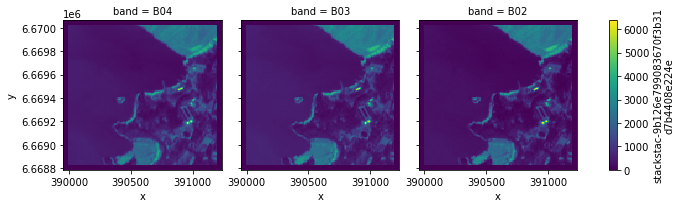

In [34]:
s2_stack[0].plot(col="band")

In [35]:
l8_original = stack(
    items=ItemCollection([best_l8_match]), assets=LANDSAT_8_RGB_BANDS, resolution=10
)

In [57]:
l8_original

,Array,Chunk
Bytes,13.56 GiB,8.00 MiB
Shape,"(1, 3, 24754, 24514)","(1, 1, 1024, 1024)"
Count,2406 Tasks,1800 Chunks
Type,float64,numpy.ndarray


As we can see from the metadata for the Xarray above, the Landsat 8 scene has a significantly larger geographic footprint, `~20,000 x ~20,000 pixels`, compared to `120 x 120 pixels` for the Sentinel-2 chips that were prepared for the dataset. We need to crop/mask the image down so they represent the exact same terrain.

Luckily, the `bounds_latlon` parameter of `stackstac` makes it easy to crop the image to this size automatically for all bands/assets requested.

In [37]:
l8_cropped = stack(
    items=ItemCollection([best_l8_match]),
    assets=LANDSAT_8_RGB_BANDS,
    bounds_latlon=source_item.bbox,
    resolution=10,
)

In [38]:
l8_cropped

<xarray.DataArray 'stackstac-dc63732d805d775831b0a32ce9a525a3' (time: 1, band: 3, y: 128, x: 128)>
dask.array<fetch_raster_window, shape=(1, 3, 128, 128), dtype=float64, chunksize=(1, 1, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * time                         (time) datetime64[ns] 2018-05-10T09:22:33.46...
    id                           (time) <U31 'LC08_L2SP_187018_20180510_02_T1'
  * band                         (band) <U5 'SR_B4' 'SR_B3' 'SR_B2'
  * x                            (x) float64 3.9e+05 3.9e+05 ... 3.912e+05
  * y                            (y) float64 6.67e+06 6.67e+06 ... 6.669e+06
    landsat:processing_level     <U4 'L2SP'
    landsat:wrs_type             <U1 '2'
    landsat:cloud_cover_land     float64 0.01
    instruments                  object {'oli', 'tirs'}
    landsat:collection_number    <U2 '02'
    landsat:wrs_path             <U3 '187'
    view:sun_elevation           float64 46.7
    eo:cloud_cover               float64 0.01
    platform                     <U9 'landsat-8'
    landsat:collection_category  <U2 'T1'
    landsat:wrs_row              <U3 '018'
    view:off_nadir               int64 0
    landsat:scene_id             <U21 'LC81870182018130LGN00'
    description                  (band) <U56 'Collection 2 Level-2 Red Band (...
    proj:epsg                    int64 32635
    view:sun_azimuth             float64 163.4
    proj:bbox                    object {6537585.0, 6785115.0, 356085.0, 6012...
    proj:shape                   object {8251, 8171}
    title                        (band) <U15 'Red Band (B4)' ... 'Blue Band (...
    proj:transform               object {0.0, -30.0, 356085.0, 6785115.0, 30.0}
    gsd                          float64 30.0
    common_name                  (band) <U5 'red' 'green' 'blue'
    center_wavelength            (band) float64 0.65 0.56 0.48
    full_width_half_max          (band) float64 0.04 0.06 0.06
    epsg                         int64 32635
Attributes:
    spec:        RasterSpec(epsg=32635, bounds=(389960, 6668780, 391240, 6670...
    crs:         epsg:32635
    transform:   | 10.00, 0.00, 389960.00|\n| 0.00,-10.00, 6670060.00|\n| 0.0...
    resolution:  10

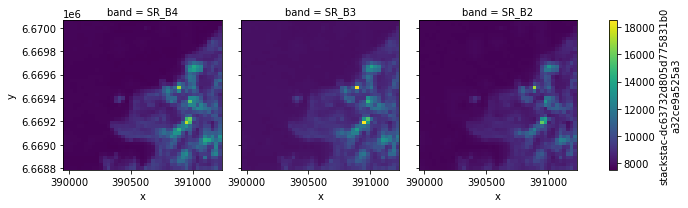

In [39]:
l8_cropped[0].plot(col="band")

Now we have a cropped Landsat 8 chip that spatially and temporally matches our Sentinel-2 source imagery and label sample from the BigEarthNet dataset.

### Launch a Dask gateway cluster for parallel processing

We will use Dask to optimize our data processing of hundreds of Landsat-8 scenes by parallelizing the workflow with a delayed computation graph. The Dask Client schedules, runs the delayed computations, and gathers the results, while the Dask Gateway provides a secure and centralized way of managing the multiple client clusters. This is especially useful for running Dask on Planetary Computer.

In [70]:
client = distributed.Client()  # you can configure Dask client parameters here
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49767,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:49781,Total threads: 2
Dashboard: http://127.0.0.1:49785/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:49770,


In [69]:
# client.close()

### Scale the workflow using Dask Delayed

These are two helper functions that we will use to encapsulate the process of creating the cropped Landsat 8 chips and write them to disk in parallel using the Dask Delayed decorator.

In [41]:
def create_landsat_8_dataarray(item_path: str) -> DataArray:
    """Creates a Landsat 8 chip from BigEarthNet label chip.

    Args:
        item_path: string path to the label item on disk

    Returns:
        Landsat 8 DataArray that has been cropped to label bbox
    """
    # read label Item object
    label_item = Item.from_file(
        os.path.join(TMP_DIR, BIGEARTHNET_LABEL_COLLECTION, item_path)
    )

    # fetch the Landsat 8 scene that best matches the label
    s2_source, l8_match = get_landsat_8_match(label_item)

    if l8_match:
        # crop L8 match to S2 dims and read image data
        l8_stack = stack(
            items=ItemCollection([l8_match]),
            assets=LANDSAT_8_RGB_BANDS,
            bounds_latlon=s2_source.bbox,
            resolution=10,
        )

        return l8_stack
    return None

In [61]:
def write_tifs_bands(l8_array: DataArray, l8_item_id: str) -> None:
    """Writes to a GeoTiff for each band in Landsat 8 DataArray

    Args:
        l8_array: the DataArray object created from the BigEarthNet label item
    """
    # write cropped L8 DataArray to a tiff file for each band
    for _band in LANDSAT_8_RGB_BANDS:
        l8_band_img = l8_array.sel(band=_band)
        l8_band_filename = os.path.join(
            TMP_DIR, OUTPUT_DIR, l8_item_id, f"{l8_item_id}_{_band}.tiff"
        )
        Path(os.path.split(l8_band_filename)[0]).mkdir(parents=True, exist_ok=True)
        l8_band_img[0].rio.to_raster(l8_band_filename)

This sets the stage for the Dask Task Scheduler by mapping all label Items to the `create_landsat_8_dataarray` function. Nothing in the task graph will actually be executed until the `.compute()` command is ran.

In [72]:
%%time
results = []
for item_path in label_item_sample[0:5]:
    results.append(create_landsat_8_dataarray(item_path))

CPU times: user 1.1 s, sys: 481 ms, total: 1.58 s
Wall time: 7.89 s


In [67]:
task_pool = []

for item_path in label_item_sample:
    delayed_task = delayed(create_landsat_8_dataarray)(item_path)
    task_pool.append(delayed_task)

Now we will persist the objects into memory and run the computations to create our DataArrays.

In [68]:
%%time
task_pool_local = compute(*task_pool, sync=True)

CPU times: user 48.2 s, sys: 1.72 s, total: 50 s
Wall time: 49.9 s


Lastly, we want to write a GeoTIFF to disk for each band of each Landsat 8 DataArray we created.

In [64]:
%%time
for l8_array in task_pool_local:
    if isinstance(l8_array, DataArray):
        write_tifs_bands(l8_array, l8_array.id.values[0])

CancelledError: create_landsat_8_dataarray-99097cdb-3ce8-4543-a1de-47ff6bf8cdc5

This confirms that folders with images were written to disk. If there is a discrepancy between the sample size and the output, it's likely that there wasn't always a matching Landsat 8 scene given the geometry and datetime parameters for a particular Sentinel-2 source Item.

In [59]:
os.listdir(TMP_DIR)

['com.apple.ScreenSaver.Engine.legacyScreenSaver',
 'com.apple.PressAndHold',
 'com.apple.avconferenced',
 'com.google.drivefs.finderhelper.findersync',
 'com.apple.appleaccountd',
 'com.apple.replayd',
 'com.apple.ScreenTimeAgent',
 'com.displaylink.DisplayLinkLoginHelper',
 'com.apple.photos.ImageConversionService',
 'com.apple.FaceTime.FTConversationService',
 'qipc_systemsem_BoseWebUpdater4a43d835f8e2d8ba59d120a7df8bcbb19328cd88',
 'com.apple.transparencyd',
 'com.apple.AppSSOAgent',
 'com.apple.quicklook.QuickLookUIService',
 'com.apple.siriactionsd',
 'com.apple.progressd',
 'com.apple.photolibraryd',
 'com.apple.trustd',
 'com.apple.siri.media-indexer',
 'com.apple.triald',
 '.com.google.Chrome.P6bcfT',
 'dropbox-electron.Fw4ulbps3nRW',
 'com.apple.ap.promotedcontentd',
 'com.apple.MobileSMS.spotlight',
 'com.apple.AMPDeviceDiscoveryAgent',
 'BoseUpdater.log',
 'com.apple.CalendarNotification.CalNCService',
 'com.apple.akd',
 'com.apple.ScreenSaver.Engine',
 'contentlinkingd',
 

In [62]:
landsat_chip_dir = os.path.join(TMP_DIR, OUTPUT_DIR)
len(os.listdir(landsat_chip_dir))

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/87/c2vwc00s3rq1xw26bz5j25rh0000gn/T/landsat_8_source'

Open one of the new Landsat 8 chips to inspect what it looks like.

In [ ]:
landsat_images = glob(f"{landsat_chip_dir}/**/*.tiff", recursive=True)
first_l8_img = rioxarray.open_rasterio(landsat_images[0])
first_l8_img.plot()

Shutdown the Dask client to cleanup cluster resources.

In [ ]:
client.shutdown()